# Bayesian SIR Model with Change Points

In [1]:
import numpy as np
from scipy.stats import binom, gamma, beta, expon, poisson, uniform, bernoulli
from joblib import Parallel, delayed
from scipy.special import gamma as gammaFunc
import random

import pandas as pd

import matplotlib.pyplot as plt

import tqdm

import itertools

## Data Simulation

In [2]:
def sim_dataset(chg_pt, scenarios, T, S0, I0, R0, n_datasets):

    N = S0 + I0 + R0
    n_sc = scenarios.shape[0]

    # create array of transmission and removal rate parameters at each time step
    beta  = np.array([[scenarios[i,(chg_pt <= t+1).sum(),0] for t in range(T)] for i in range(n_sc)])
    gamma = np.array([[scenarios[i,(chg_pt <= t+1).sum(),1] for t in range(T)] for i in range(n_sc)])


    Delta_I = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    Delta_R = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    S       = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    I       = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    R       = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)

    Delta_I[:,:,0] = binom.rvs(S0, 1-np.exp(-beta[:,0]*I0/N), size=(n_datasets, n_sc))
    Delta_R[:,:,0] = binom.rvs(I0, gamma[:,0], size=(n_datasets, n_sc))
    S[:,:,0]       = S0 - Delta_I[:,:,0]
    I[:,:,0]       = I0 + Delta_I[:,:,0] - Delta_R[:,:,0]
    R[:,:,0]       = R0 + Delta_R[:,:,0]

    for t in range(1, T):
        Delta_I[:,:,t] = binom.rvs(S[:,:,t-1], 1-np.exp(-beta[:,t]*I[:,:,t-1]/N))
        Delta_R[:,:,t] = binom.rvs(I[:,:,t-1], gamma[:,t])
        S[:,:,t]       = S[:,:,t-1] - Delta_I[:,:,t]
        I[:,:,t]       = I[:,:,t-1] + Delta_I[:,:,t] - Delta_R[:,:,t]
        R[:,:,t]       = R[:,:,t-1] + Delta_R[:,:,t]

    return Delta_I, Delta_R, S, I, R

In [3]:
def plot_SRI(S, I, R, sc=0, d=None, start_cond=(999_950, 50, 0), tot=1_000_000, time=100):

    if d is None:
        S = np.expand_dims(np.mean(S, axis=0), 0)
        I = np.expand_dims(np.mean(I, axis=0), 0)
        R = np.expand_dims(np.mean(R, axis=0), 0)
        d = 0

    S = np.concatenate([[start_cond[0]], S[d,sc]])
    I = np.concatenate([[start_cond[1]], I[d,sc]])
    R = np.concatenate([[start_cond[2]], R[d,sc]])

    # plot
    fig, ax = plt.subplots()

    y = np.vstack([S, I, R])
    ax.stackplot(np.arange(time+1), y/tot, labels=["S","I","R"], alpha=0.8)

    ax.set_xlabel("Day")
    ax.set_ylabel("Proportion")
    ax.set_xticks(np.concatenate([[0], np.arange(25, time+1, 25)]))
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend(loc="upper right")

    plt.show()

### Example

In [4]:
T = 100
N = 1_000_000

chg_pt = np.array([26, 51, 76])

sc_1 = [(0.3, 0.05), (0.4, 0.15), (0.25, 0.2),  (0.2,  0.25)]
sc_2 = [(0.4, 0.1),  (0.4, 0.25), (0.25, 0.25), (0.25, 0.4) ]
sc_3 = [(0.5, 0.1),  (0.3, 0.3),  (0.4,  0.2),  (0.2,  0.4) ]
scenarios = np.array([sc_1, sc_2, sc_3])

S0 = N-50
I0 = 50
R0 = 0

n_datasets = 100

In [5]:
Delta_I, Delta_R, S, I, R =  sim_dataset(chg_pt, scenarios, T, S0, I0, R0, n_datasets)
#for i in range(len(scenarios)):
 #   print(f"Scenario {i+1}:")
#    plot_SRI(S, I, R, sc=i)

## Gibbs Sampling

In [6]:
S_obs = np.concatenate(([S0],S[0,0]))
I_obs = np.concatenate(([I0],I[0,0]))
R_obs = np.concatenate(([R0],R[0,0]))
PI_obs = I_obs/N
N_infect_obs = np.concatenate(([50],Delta_I[0,0]))
N_recovery_obs = np.concatenate(([0],Delta_R[0,0]))

data = pd.DataFrame({
        'susceptible': S_obs,
        'infects': I_obs,
        'recovered': R_obs,
        'PI': PI_obs,
        'deltaI': N_infect_obs,
        'deltaR': N_recovery_obs
    })

In [7]:
data

,susceptible,infects,recovered,PI,deltaI,deltaR
0,999950,50,0,0.000050,50,0
1,999936,63,1,0.000063,14,1
2,999911,82,7,0.000082,25,6
3,999887,100,13,0.000100,24,6
4,999858,126,16,0.000126,29,3
...,...,...,...,...,...,...
96,166803,21,833176,0.000021,2,10
97,166803,13,833184,0.000013,0,8
98,166802,12,833186,0.000012,1,2
99,166801,11,833188,0.000011,1,2


In [8]:
def calculate_contact_hat_parallel(pp_lambda_t):
    pp, lambda_t = pp_lambda_t
    return np.sum(poisson.ppf(pp, lambda_t))

def gibbs_sampling(data, samples=10000, T_max=100, burnin=1000, thinning=10):
    
    ############# data
    # Data is expected to be a dataframe with 101 rows (100 steps + initial one)
    # OBS: the initial row should display the starting values 
    #      for Susceptible (S), Infected (I), and Recovered (R), with zero values in the 
    #      columns representing changes (deltas) over time.
    
    I_obs = data["infects"].values
    S_obs = data["susceptible"].values
    PI_obs = data["PI"].values
    N_infect_obs = data["deltaI"].values[1:]
    N_recovery_obs = data["deltaR"].values[1:]
    

    #######################
    ##  HYPERPARAMETERS  ##
    #######################
    
    p_a = 1/T_max**4
    p_b = 2 - p_a
    
    b_shape = 0.1
    b_rate = 0.1
    r_shape = 0.1
    r_rate = 0.1
    
    gamma_b_shape = gammaFunc(b_shape)
    gamma_r_shape = gammaFunc(r_shape)
    

    ######################
    ##  INITIALIZATION  ##
    ######################
    
    ##### delta
    Delta_hat = np.zeros(shape=T_max, dtype=int)
    Delta_hat[0] = 1
    Stage_hat = np.cumsum(Delta_hat, dtype=int)-1
    K_hat     = np.sum(Delta_hat, dtype=int)

    ##### b and r
    b_hat    = gamma.rvs(a=b_shape, scale=1/b_rate, size=K_hat)
    r_hat    = gamma.rvs(a=r_shape, scale=1/r_rate, size=K_hat)
    
    ##### beta and gamma
    beta_hat    = expon.rvs(scale=1/b_hat[Stage_hat[0]], size=T_max)
    gamma_hat   = beta.rvs(a=r_hat[Stage_hat[0]], b=1, size=T_max)
    lambda_t    = beta_hat*PI_obs[:-1]
    p_upper     = 1 - poisson.cdf(0, lambda_t)
    pp          = [uniform.rvs(size=N_infect_obs[t]) * p_upper[t] + (1 - p_upper[t]) for t in range(T_max)]
    contact_hat = np.array(Parallel(n_jobs=-1)(delayed(calculate_contact_hat_parallel)((pp[t], lambda_t[t],)) for t in range(T_max)))
    
    
    beta_hat    = gamma.rvs(a=contact_hat + 1, scale=1/(b_hat[Stage_hat] + PI_obs[:-1]*S_obs[:-1]))
    gamma_hat   = beta.rvs(a=N_recovery_obs + r_hat[Stage_hat], b=1 + I_obs[:-1] - N_recovery_obs)
    lambda_t    = beta_hat * PI_obs[:-1]
    p_upper     = 1 - poisson.cdf(0, lambda_t)
    pp          = [uniform.rvs(size=N_infect_obs[t]) * p_upper[t] + (1 - p_upper[t]) for t in range(T_max)]
    contact_hat = np.array(Parallel(n_jobs=-1)(delayed(calculate_contact_hat_parallel)((pp[t], lambda_t[t],)) for t in range(T_max)))
    
    
    print("Initialization:\n")
    print("Delta_hat:",Delta_hat)
    print("b_hat:",b_hat)
    print("r_hat:",r_hat)
    print("beta_hat:",beta_hat)
    print("gamma_hat:",gamma_hat)
    print("----------------------------------------------------")
    print("----------------------------------------------------")
    

    ################
    ##  SAMPLING  ##
    ################
    
    Delta_all = []
    Stage_all = []
    b_all     = []
    r_all     = []
    beta_all  = []
    gamma_all = []
    
    for step in tqdm.tqdm(range(samples)):
        
        ###### delta_hat sampling
        ## add–delete–swap - proposal step
        # -1 delete
        # 0 swap
        # +1 add
                
        if K_hat==1:
            change_type = 1
        
        elif K_hat==T_max:
            change_type = -1

        else:
            change_type = np.random.choice([-1, 0, 1])
            
        Delta_hat_candidate = Delta_hat.copy()
        
        if change_type != 0:
            
            if change_type == 1:
                possible_change_indices = np.where(Delta_hat[1:] == 0)[0]+1
            elif change_type == -1:
                possible_change_indices = np.where(Delta_hat[1:] == 1)[0]+1
            index_to_change = np.random.choice(possible_change_indices)

            Delta_hat_candidate[index_to_change] = 1 - Delta_hat_candidate[index_to_change]
            Stage_hat_candidate = np.cumsum(Delta_hat_candidate)-1

            if change_type == 1:
                possible_change_indices_candidate = np.where(Delta_hat_candidate[1:] == 1)[0] + 1
                phase_original  = np.array([Stage_hat[index_to_change]])
                phase_candidate = np.array([Stage_hat[index_to_change], Stage_hat_candidate[index_to_change]])
            elif change_type == -1:
                possible_change_indices_candidate = np.where(Delta_hat_candidate[1:] == 0)[0] + 1
                phase_original  = np.array([Stage_hat[index_to_change], Stage_hat_candidate[index_to_change]])
                phase_candidate = np.array([Stage_hat_candidate[index_to_change]])
        
            logp_original = 0
            logp_candidate = 0

            for i in phase_original:
                L_i_original = np.where(Stage_hat == i)[0]

                logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + b_shape)) \
                               - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                               - (b_shape + len(L_i_original)) * np.log(b_rate + np.sum(beta_hat[L_i_original]))
                logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + r_shape)) \
                               - np.log(gamma_r_shape) + r_shape * np.log(r_rate) \
                               - (r_shape + len(L_i_original)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_original])))
                logp_original -= np.sum(np.log(np.arange(1, len(L_i_original))))

            for i in phase_candidate:
                L_i_candidate = np.where(Stage_hat_candidate == i)[0]

                logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + b_shape)) \
                                - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                                - (b_shape + len(L_i_candidate)) * np.log(b_rate + np.sum(beta_hat[L_i_candidate]))
                logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + r_shape)) \
                                - np.log(gamma_r_shape) + r_shape * np.log(r_rate) \
                                - (r_shape + len(L_i_candidate)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_candidate])))
                logp_candidate -= np.sum(np.log(np.arange(1, len(L_i_candidate))))

            logp_candidate += np.log(p_a / p_b) + np.log((3 - 2 * (K_hat == 1)) \
                            * len(possible_change_indices) / (3 - 2 * ((K_hat + 1) == T_max)) / len(possible_change_indices_candidate))

            ratio = np.exp(min([0, logp_candidate - logp_original]))

        elif change_type == 0:
            
            possible_change_indices = np.where(np.abs(Delta_hat[1:-1] - Delta_hat[2:]) == 1)[0]+1
            index_to_change = np.random.choice(possible_change_indices, 1)

            Delta_hat_candidate[index_to_change + np.array([0, 1])] = Delta_hat_candidate[index_to_change + np.array([1, 0])]
            Stage_hat_candidate = np.cumsum(Delta_hat_candidate)-1
   
            possible_change_indices_candidate = np.where(np.abs(Delta_hat_candidate[1:-1] - Delta_hat_candidate[2:]) == 1)[0]+1
        
            phase = np.array([Stage_hat[index_to_change], Stage_hat_candidate[index_to_change]])
    
            logp_original = 0
            logp_candidate = 0
        
            for i in phase:
                L_i_original = np.where(Stage_hat == i)[0]
                logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + b_shape)) \
                               - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                               - (b_shape + len(L_i_original)) * np.log(b_rate + np.sum(beta_hat[L_i_original]))
                logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + r_shape)) \
                               - np.log(gamma_b_shape) + r_shape * np.log(r_rate) \
                               - (r_shape + len(L_i_original)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_original])))
                logp_original -= np.sum(np.log(np.arange(1, len(L_i_original))))

                L_i_candidate = np.where(Stage_hat_candidate == i)[0]
                logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + b_shape)) \
                                - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                                - (b_shape + len(L_i_candidate)) * np.log(b_rate + np.sum(beta_hat[L_i_candidate]))
                logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + r_shape)) \
                                - np.log(gamma_b_shape) + r_shape * np.log(r_rate) \
                                - (r_shape + len(L_i_candidate)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_candidate])))
                logp_candidate -= np.sum(np.log(np.arange(1, len(L_i_candidate))))

            ratio = np.exp(min([0, logp_candidate - logp_original + np.log(len(possible_change_indices) / len(possible_change_indices_candidate))]))
        
        cxx = np.random.binomial(1, ratio)      
        if cxx == 1:
            Delta_hat = Delta_hat_candidate
            Stage_hat = Stage_hat_candidate
        
        
        ##### b and r sampling
            
        K_hat = np.sum(Delta_hat)
        
        b_hat = np.zeros(K_hat)
        r_hat = np.zeros(K_hat)
        for i in range(K_hat):
            L_i = np.where(Stage_hat == i)[0]
            b_hat[i] = gamma.rvs(size=1, a=(b_shape + len(L_i)), scale=1/(b_rate + np.sum(beta_hat[L_i])))
            r_hat[i] = gamma.rvs(size=1, a=(r_shape + len(L_i)), scale=1/(r_rate + np.sum(-np.log(gamma_hat[L_i]))))
    
        
        ##### beta and gamma sampling

        beta_hat    = gamma.rvs(a=contact_hat + 1, scale=1/(b_hat[Stage_hat] + PI_obs[:-1]*S_obs[:-1]))
        gamma_hat   = beta.rvs(a=N_recovery_obs + r_hat[Stage_hat], b=1 + I_obs[:-1] - N_recovery_obs)
        lambda_t    = beta_hat * PI_obs[:-1]
        p_upper     = 1 - poisson.cdf(0, lambda_t)
        pp          = [uniform.rvs(size=N_infect_obs[t]) * p_upper[t] + (1 - p_upper[t]) for t in range(T_max)]
        contact_hat = np.array(Parallel(n_jobs=-1)(delayed(calculate_contact_hat_parallel)((pp[t], lambda_t[t],)) for t in range(T_max)))
    
       


        if step % 100 == 0 and step != 0:
            print("\nStep:",step)
            #print("Delta_hat:",Delta_hat)
            #print("b_hat:",b_hat)
            #print("r_hat:",r_hat)
            #print("beta_hat:",beta_hat)
            #print("gamma_hat:",gamma_hat)
            print("----------------------------------------------------")
            
        Delta_all.append(Delta_hat)
        Stage_all.append(Stage_hat)
        b_all.append(b_hat)
        r_all.append(r_hat)
        beta_all.append(beta_hat)
        gamma_all.append(gamma_hat)
  
    # Creazione del DataFrame
    MCMC_chain = {
        'Delta': Delta_all[burnin::thinning],
        'Stage': Stage_all[burnin::thinning],
        'b': b_all[burnin::thinning],
        'r': r_all[burnin::thinning],
        'beta': beta_all[burnin::thinning],
        'gamma': gamma_all[burnin::thinning]
            }
    
    return MCMC_chain

In [9]:
MCMC_chain=gibbs_sampling(data, samples=200, burnin=0, thinning=1)

Initialization:

Delta_hat: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
b_hat: [0.04276104]
r_hat: [1.97120362e-06]
beta_hat: [0.37979216 0.30199736 0.32211452 0.28028739 0.28051707 0.41334862
 0.18734764 0.25540136 0.38037777 0.31036531 0.32039152 0.23483006
 0.31060717 0.37975842 0.28284824 0.28688241 0.31885251 0.30652864
 0.31827433 0.29517072 0.32286136 0.31198213 0.33155459 0.35330658
 0.30985973 0.41782019 0.41072029 0.51347597 0.4143435  0.85406969
 0.5638955  1.35342138 0.47399898 0.44566388 0.46527524 1.40602817
 1.25494283 1.42773108 0.84011176 1.76612399 0.70656714 0.40636452
 3.4555163  2.47276604 1.72636117 3.00512672 0.52807749 3.99342297
 6.0442328  1.69872363 3.99724711 0.28926536 0.52485164 0.44617111
 0.34725266 0.27371394 0.88847285 0.25436772 0.39119397 0.5318066
 0.31492166 0.294585   0.71125812 0.38700008 

 50%|█████     | 101/200 [00:57<00:56,  1.75it/s]


Step: 100
----------------------------------------------------


100%|██████████| 200/200 [01:55<00:00,  1.73it/s]


### Estimators

In [116]:
def compute_loss(delta, Q_tt):
    stage = np.cumsum(delta, dtype=int)-1
    Q_candidate = (stage[:, np.newaxis] == stage)
    return np.sum(np.abs(Q_candidate - Q_tt))

def get_estimators(chain, T_max=100, samples=1000):

    ##### delta

    delta = np.array(MCMC_chain["Delta"])
    stage = np.array(MCMC_chain["Stage"])
    masks = (stage[:, :, np.newaxis] == stage[:, np.newaxis, :])
    Q_ttprime = np.sum(masks, axis=0)/samples

    Delta_final = np.zeros(shape=T_max, dtype=int)
    Delta_final[0] = 1
    Stage_final = np.cumsum(Delta_final, dtype=int)-1 
    current_loss = compute_loss(Delta_final, Q_ttprime)

    check_add_drop = True
    check_swap = True
    while(check_add_drop==True or check_swap==True):
        # check add or drop
        candidates_loss = np.zeros(shape=(T_max))
        for i in range(1, T_max):
            Delta_candidate = Delta_final.copy()
            Delta_candidate[i] = 1-Delta_candidate[i]
            candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
        index_min = np.argmin(candidates_loss[1:])+1
        if candidates_loss[index_min] < current_loss:
            current_loss = candidates_loss[index_min]
            Delta_final[index_min] = 1-Delta_final[index_min]
            check_add_drop = True
        else:
            check_add_drop = False

        possible_change_indices = np.where(np.abs(Delta_final[1:-1] - Delta_final[2:]) == 1)[0]+1
        candidates_loss = np.zeros(shape=(len(possible_change_indices)))
        for i, idx in enumerate(possible_change_indices):
            Delta_candidate = Delta_final.copy()
            Delta_candidate[idx+np.array([0,1])] = Delta_candidate[idx+np.array([1,0])]
            candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
        index_min = np.argmin(candidates_loss)
        if candidates_loss[index_min] < current_loss:
            current_loss = candidates_loss[index_min]
            Delta_candidate[possible_change_indices[index_min]+np.array([0,1])] = Delta_candidate[possible_change_indices[index_min]+np.array([1,0])]
            check_swap = True
        else:
            check_swap = False

        # check swap
        if np.sum(Delta_final) in np.arange(1,T_max-1):
            possible_change_indices = np.where(np.abs(Delta_final[1:-1] - Delta_final[2:]) == 1)[0]+1
            candidates_loss = np.zeros(shape=(len(possible_change_indices)))
            for i, idx in enumerate(possible_change_indices):
                Delta_candidate = Delta_final.copy()
                Delta_candidate[idx+np.array([0,1])] = Delta_candidate[idx+np.array([1,0])]
                candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
            index_min = np.argmin(candidates_loss)
            if candidates_loss[index_min] < current_loss:
                current_loss = candidates_loss[index_min]
                Delta_candidate[possible_change_indices[index_min]+np.array([0,1])] = Delta_candidate[possible_change_indices[index_min]+np.array([1,0])]
                check_swap = True
            else:
                check_swap = False


    ##### beta and gamma
                
    b = np.array([[MCMC_chain["b"][s][stage[s][t]] for t in range(T_max)] for s in range(samples)])
    r = np.array([[MCMC_chain["r"][s][stage[s][t]] for t in range(T_max)] for s in range(samples)])
    beta_final  = np.sum(1/b, axis=0)/samples
    gamma_final = np.sum(r/(1+r), axis=0)/samples


    return Delta_final, beta_final, gamma_final
        

In [134]:
delta_est, beta_est, gamma_est = get_estimators(MCMC_chain, 100, 200)
stage_est = np.cumsum(delta_est)-1

In [185]:
delta_true = np.array([(t in chg_pt or t==1) for t in range(1, T_max+1)]).astype(int)
stage_true = np.cumsum(delta_true)-1
print(f"True change points={np.where(delta_true==1)[0]}")
print(f"Predicted change points={np.where(delta_est==1)[0]}")

True change points=[ 0 25 50 75]
Predicted change points=[ 0 20 52 79]


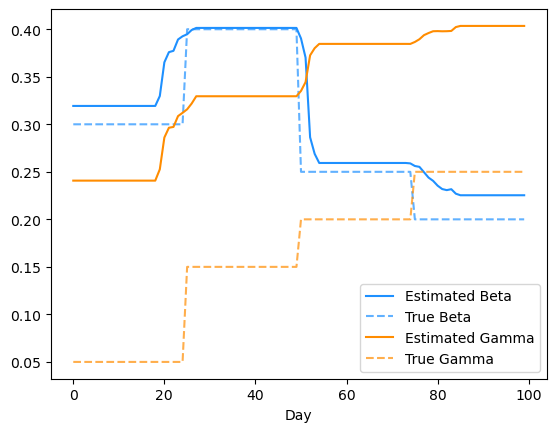

In [122]:
n_sc=3
true_beta  = np.array([[scenarios[i,(chg_pt <= t+1).sum(),0] for t in range(T)] for i in range(n_sc)])
true_gamma = np.array([[scenarios[i,(chg_pt <= t+1).sum(),1] for t in range(T)] for i in range(n_sc)])

fig, ax = plt.subplots()
plt.plot(beta_est, label="Estimated Beta", color='dodgerblue')
plt.plot(true_beta[0], label="True Beta", color='dodgerblue', linestyle='dashed', alpha=0.7)
plt.plot(gamma_est, label="Estimated Gamma", color='darkorange')
plt.plot(true_gamma[0], label="True Gamma", color='darkorange', linestyle='dashed', alpha=0.7)
ax.set_xlabel("Day")
plt.legend(loc="best")

### Agreement with True Values

In [141]:
def comp_ARI(true, estim, T_max=100):

    comb = np.array(list(itertools.combinations(range(T_max), 2))).T
    true_mask = (true[comb[0]] == true[comb[1]]).astype(int)
    estim_mask = (estim[comb[0]] == estim[comb[1]]).astype(int)

    TP = np.mean(true_mask*estim_mask)
    FP = np.mean((1-true_mask)*estim_mask)
    FN = np.mean(true_mask*(1-estim_mask))
    TN = np.mean((1-true_mask)*(1-estim_mask))
    num = TP+TN-(TP+FP)*(TP+FN)-(TN+FP)*(TN+FN)
    den = 1-(TP+FP)*(TP+FN)-(TN+FP)*(TN+FN)

    ARI = num/den

    return ARI


In [168]:
def comp_MI(true, estim, T_max=100):
    n_kkprime = np.histogram2d(true, estim, bins=(np.max(true)+1, np.max(estim)+1))[0]
    n_k = np.sum(n_kkprime, axis=1)
    n_kprime = np.sum(n_kkprime, axis=0)
    
    MI = np.sum(n_kkprime/T_max*np.log((n_kkprime+(n_kkprime==0))*T_max/np.outer(n_k, n_kprime)))
    return MI

In [176]:
ARI = comp_ARI(stage_true, stage_est)
MI = comp_MI(stage_true, stage_est)
print(f"ARI = {ARI} out of 1\nMI = {MI} out of 1.386")

ARI = 0.7248145528709354 out of 1
MI = 1.0630521579612635 out of 1.386
